## Script to Find and List Files in a Directory

In [1]:
import os
import glob

def find_tsv_files(directory):
    search_pattern = os.path.join(directory, '*.tsv')
    tsv_files = glob.glob(search_pattern)
    updated_files = [t.replace("\\", "/") for t in tsv_files]
    tsv_dict = {os.path.splitext(os.path.basename(t))[0]: t for t in updated_files}
    return tsv_dict
    
directory_path = '../Dataset/'
tsv_dict = find_tsv_files(directory_path)

for file_name, file_path in tsv_dict.items():
    print(f"{file_name}: {file_path}")

contacts: ../Dataset/contacts.tsv
content: ../Dataset/content.tsv
events: ../Dataset/events.tsv
organisations: ../Dataset/organisations.tsv
recommendations: ../Dataset/recommendations.tsv
users: ../Dataset/users.tsv


# ----------------------------------------------------------------------------------------------------------------

# Data Analysis for Each Files

### Importing Libraries

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from urllib.parse import urlparse
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Display the info and column details

In [3]:
def data_info(df):
    # Display basic information about the DataFrame
    print("info")
    print(df.info())
    print("-" * 125)

    # Display the columns in the DataFrame
    print("columns")
    print(df.columns)
    print("-" * 125)

### Data preprocessing

In [4]:
def data_clean_up(df):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Display missing values
    print(missing_values)
    
    # Calculate the total number of rows
    total_rows = df.shape[0]

    # Identify columns with more than half of the rows being null
    columns_with_many_nulls = missing_values[missing_values > total_rows / 2].index.tolist()

    # Display the columns with more than half rows null
    print()
    print("columns with most of the values null")
    print(columns_with_many_nulls)
    
    return df.drop(columns=columns_with_many_nulls)

### Generating Descriptive Statistics for Numeric and Non-Numeric Columns

In [5]:
def column_stat(df_cleaned):
    # Separate numeric and non-numeric columns
    numeric_columns = df_cleaned.select_dtypes(include=['number', 'datetime']).columns
    non_numeric_columns = df_cleaned.select_dtypes(include=['object']).columns

    # Descriptive statistics for numeric columns
    numeric_stats = df_cleaned[numeric_columns].describe().transpose()

    # Descriptive statistics for non-numeric columns
    non_numeric_stats = df_cleaned[non_numeric_columns].describe().transpose()
    
    return numeric_stats, non_numeric_stats

### Displaying Bar Graphs with Labels

In [6]:
# .str.strip().str.rstrip('.,') is done to handle Los Angeles and Los Angeles, values
def get_distribution(df, column):
    return df[column].str.strip().str.rstrip('.,').value_counts()

In [7]:
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

def display_graph(distribution, title, xlabel, ylabel, width= 15, head = False):
    plt.figure(figsize=(width, 6))
    rect = distribution.plot(kind='bar')
    if head:
        rect = distribution.head(20).plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    add_labels(rect.patches)
    plt.show()
    
def plot_sentiment_distribution(data, title, xlabel, ylabel, width=15):
    plt.figure(figsize=(width, 6))
    ax = sns.histplot(data, bins=30, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    add_labels(ax.patches)
    plt.show()

### Displaying a Word Cloud for Text Data

In [8]:
# Generate word cloud for the description and display it
def generate_word_cloud(all_descriptions):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

    # Display the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# ----------------------------------------------------------------------------------------------------------------

# Contacts Dataset

In [9]:
contacts_df = pd.read_csv(tsv_dict['contacts'], sep='\t')
contacts_df

,id,first_name,last_name,email,role_id,organisation_id,picture_name,position,gender,city,country,state,created,phone_number,linkedin_url,description
0,145,Don,Lofton,don@gomightymotors.com,0,NaN,NaN,NaN,NaN,Adrian,United States,Michigan,1715265341,NaN,https://www.linkedin.com/in/don-lofton-9a883322,"President/CEO, Elite Group Int'l Inc. Adrian Taxi"
1,146,Anthony,Domangue,Anthony_Domangue@temporary.org,0,NaN,NaN,NaN,NaN,St. Peters,United States,Missouri,1715265341,NaN,https://www.linkedin.com/in/anthony-domangue-8...,Cannabis Cultivator & Consultant
2,147,Kyle,Esplin,Kyle_Esplin@temporary.org,0,NaN,NaN,NaN,NaN,Forfar,Scotland,Angus,1715265341,NaN,https://www.linkedin.com/in/kyle-esplin-03981b4b,"Entertainer: Stage shows, piano sessions & pre..."
3,148,Krysta,Jones,krysta@thehighcountrygirls.com,0,NaN,NaN,NaN,NaN,Miami,United States,Florida,1715265341,NaN,https://www.linkedin.com/in/krysta-jones-860b5...,I help build brand through organic and authent...
4,149,Angel,Colon,angel@entorogroup.com,0,NaN,NaN,NaN,NaN,New York,United States,New York,1715265341,NaN,https://www.linkedin.com/in/angeljcolon/,Managing Director at NY Capital Management Gro...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,442,Tatiana,Calvo,Tatiana_Calvo@temporary.org,0,NaN,NaN,NaN,NaN,Denver,United States,Colorado,1715265341,NaN,https://www.linkedin.com/in/tatiana-calvo-795b...,Regulatory Attorney | Plant Medicines
296,443,Yadi,Alarcon,Yadi_Alarcon@temporary.org,0,NaN,NaN,NaN,NaN,Chicago,United States,Illinois,1715265341,NaN,https://www.linkedin.com/in/yadialarcon/,"Cannabis Brand Representative, Field, Event an..."
297,444,Peter,Barsoom,Peter_Barsoom@temporary.org,0,NaN,NaN,NaN,NaN,New York,United States,New York,1715265341,NaN,https://www.linkedin.com/in/pbarsoom/,"Founder and CEO, 1906"
298,445,Maria,Stabler,Maria_Stabler@temporary.org,0,NaN,NaN,NaN,NaN,Los Angeles,United States,California,1715265341,NaN,https://www.linkedin.com/in/mariastabler/,Director of Sales CA


In [10]:
data_info(contacts_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               300 non-null    int64  
 1   first_name       300 non-null    object 
 2   last_name        300 non-null    object 
 3   email            300 non-null    object 
 4   role_id          300 non-null    int64  
 5   organisation_id  0 non-null      float64
 6   picture_name     0 non-null      float64
 7   position         0 non-null      float64
 8   gender           0 non-null      float64
 9   city             290 non-null    object 
 10  country          300 non-null    object 
 11  state            295 non-null    object 
 12  created          300 non-null    int64  
 13  phone_number     0 non-null      float64
 14  linkedin_url     300 non-null    object 
 15  description      298 non-null    object 
dtypes: float64(5), int64(3), object(8)
memory usage: 37.6+ KB

In [11]:
# Drop columns with more than 50% missing values
contacts_df_cleaned = data_clean_up(contacts_df)

id                   0
first_name           0
last_name            0
email                0
role_id              0
organisation_id    300
picture_name       300
position           300
gender             300
city                10
country              0
state                5
created              0
phone_number       300
linkedin_url         0
description          2
dtype: int64

columns with most of the values null
['organisation_id', 'picture_name', 'position', 'gender', 'phone_number']


In [12]:
# Fill missing values in 'city' and 'state' with 'Unknown'
contacts_df_cleaned['city'].fillna('Unknown', inplace=True)
contacts_df_cleaned['state'].fillna('Unknown', inplace=True)

# Fill missing values in 'description' with an empty string
contacts_df_cleaned['description'].fillna('', inplace=True)

In [13]:
contacts_df_cleaned

,id,first_name,last_name,email,role_id,city,country,state,created,linkedin_url,description
0,145,Don,Lofton,don@gomightymotors.com,0,Adrian,United States,Michigan,1715265341,https://www.linkedin.com/in/don-lofton-9a883322,"President/CEO, Elite Group Int'l Inc. Adrian Taxi"
1,146,Anthony,Domangue,Anthony_Domangue@temporary.org,0,St. Peters,United States,Missouri,1715265341,https://www.linkedin.com/in/anthony-domangue-8...,Cannabis Cultivator & Consultant
2,147,Kyle,Esplin,Kyle_Esplin@temporary.org,0,Forfar,Scotland,Angus,1715265341,https://www.linkedin.com/in/kyle-esplin-03981b4b,"Entertainer: Stage shows, piano sessions & pre..."
3,148,Krysta,Jones,krysta@thehighcountrygirls.com,0,Miami,United States,Florida,1715265341,https://www.linkedin.com/in/krysta-jones-860b5...,I help build brand through organic and authent...
4,149,Angel,Colon,angel@entorogroup.com,0,New York,United States,New York,1715265341,https://www.linkedin.com/in/angeljcolon/,Managing Director at NY Capital Management Gro...
...,...,...,...,...,...,...,...,...,...,...,...
295,442,Tatiana,Calvo,Tatiana_Calvo@temporary.org,0,Denver,United States,Colorado,1715265341,https://www.linkedin.com/in/tatiana-calvo-795b...,Regulatory Attorney | Plant Medicines
296,443,Yadi,Alarcon,Yadi_Alarcon@temporary.org,0,Chicago,United States,Illinois,1715265341,https://www.linkedin.com/in/yadialarcon/,"Cannabis Brand Representative, Field, Event an..."
297,444,Peter,Barsoom,Peter_Barsoom@temporary.org,0,New York,United States,New York,1715265341,https://www.linkedin.com/in/pbarsoom/,"Founder and CEO, 1906"
298,445,Maria,Stabler,Maria_Stabler@temporary.org,0,Los Angeles,United States,California,1715265341,https://www.linkedin.com/in/mariastabler/,Director of Sales CA


In [14]:
numeric_stats, non_numeric_stats = column_stat(contacts_df_cleaned)

numeric_stats

,count,mean,std,min,25%,50%,75%,max
id,300.0,2.960133e+02,87.265289,1.450000e+02,2.207500e+02,2.965000e+02,3.712500e+02,4.460000e+02
role_id,300.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
created,300.0,1.715265e+09,0.000000,1.715265e+09,1.715265e+09,1.715265e+09,1.715265e+09,1.715265e+09


In [15]:
non_numeric_stats

,count,unique,top,freq
first_name,300,245,Anthony,4
last_name,300,284,Rodriguez,3
email,300,300,don@gomightymotors.com,1
city,300,124,Los Angeles,33
country,300,6,United States,292
state,300,37,California,73
linkedin_url,300,297,https://www.linkedin.com/in/avaconcepcion?utm_...,2
description,300,294,"Acting Chair MA Cannabis Commission, Harvard Y...",2


In [16]:
# Analyze the distribution of contacts by country
country_distribution = get_distribution(contacts_df_cleaned, 'country')

# Analyze the distribution of contacts by state
state_distribution = get_distribution(contacts_df_cleaned, 'state')

# Analyze the distribution of contacts by city
city_distribution = get_distribution(contacts_df_cleaned, 'city')

# Analyze the distribution of roles based on 'role_id'
role_distribution = contacts_df_cleaned['role_id'].value_counts()

# Analyze the timestamps in the 'created' column
contacts_df_cleaned['created'] = pd.to_datetime(contacts_df_cleaned['created'], unit='s')
creation_dates = contacts_df_cleaned['created'].dt.date.value_counts().sort_index()

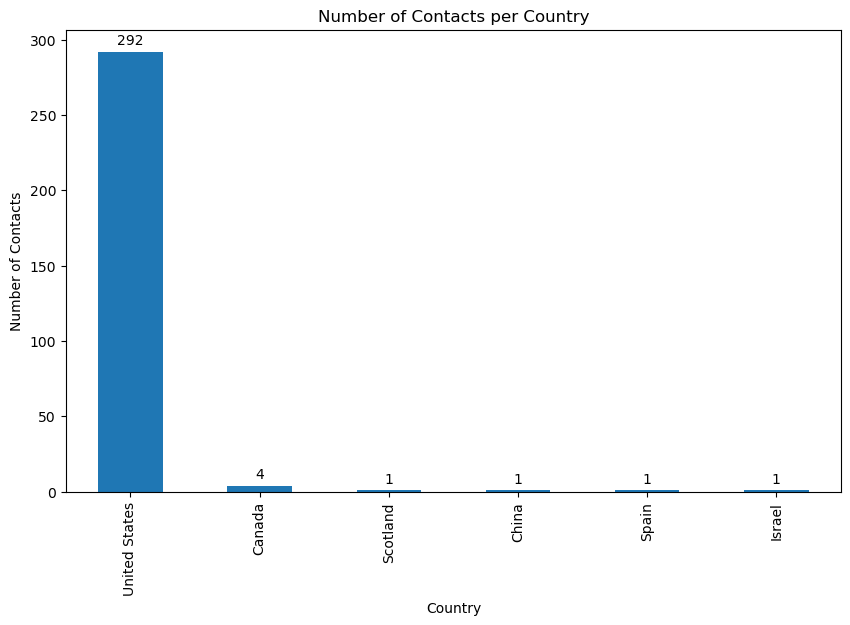

In [17]:
# Bar chart for country distribution with labels
display_graph(country_distribution, 'Number of Contacts per Country', 'Country', 'Number of Contacts', 10)

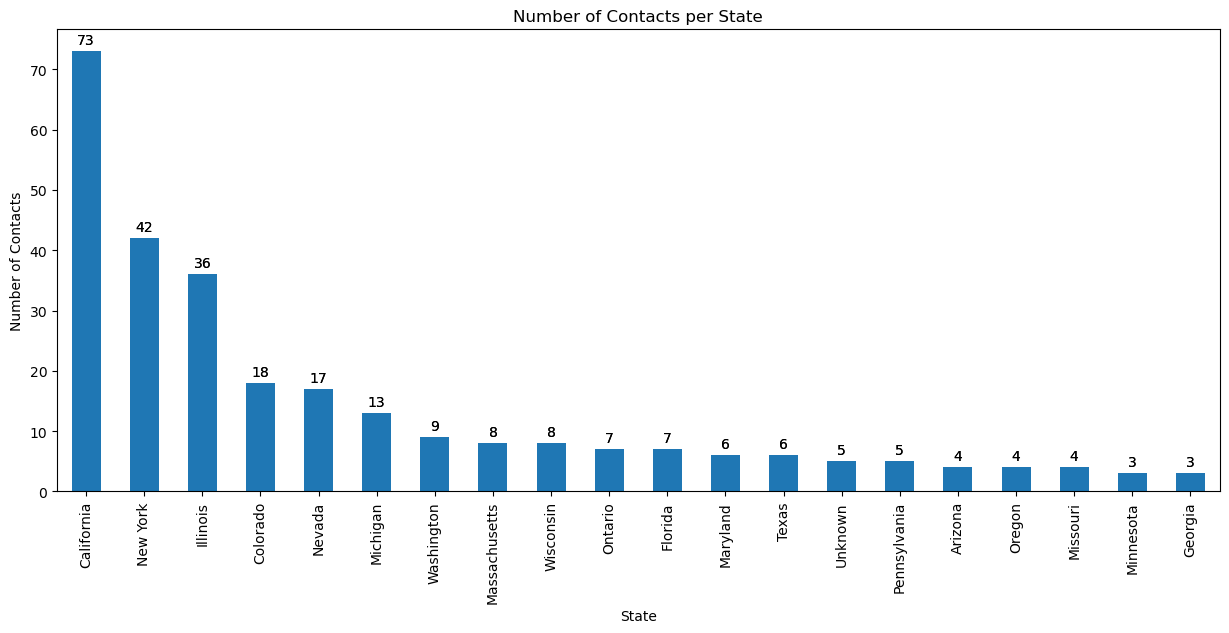

In [18]:
# Bar chart for state distribution with labels
display_graph(state_distribution, 'Number of Contacts per State', 'State', 'Number of Contacts', 15, True)

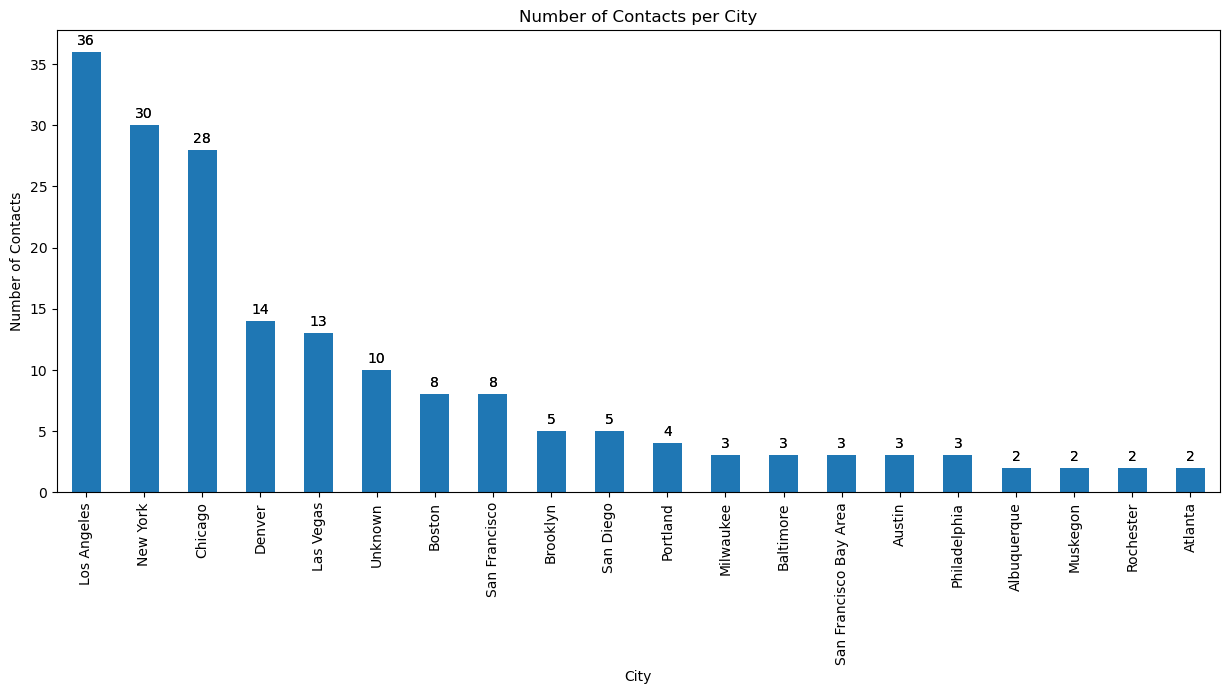

In [19]:
# Bar chart for city distribution with labels
display_graph(city_distribution, 'Number of Contacts per City', 'City', 'Number of Contacts', 15, True)

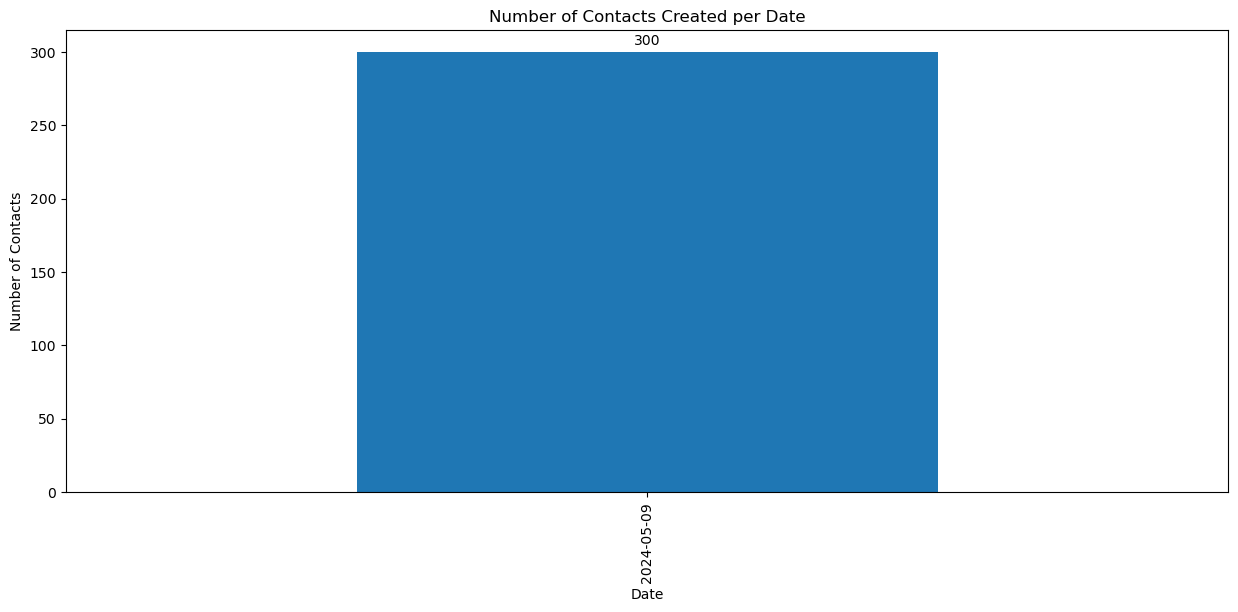

In [20]:
# Histogram for creation dates with labels
display_graph(creation_dates, 'Number of Contacts Created per Date', 'Date', 'Number of Contacts', 15)

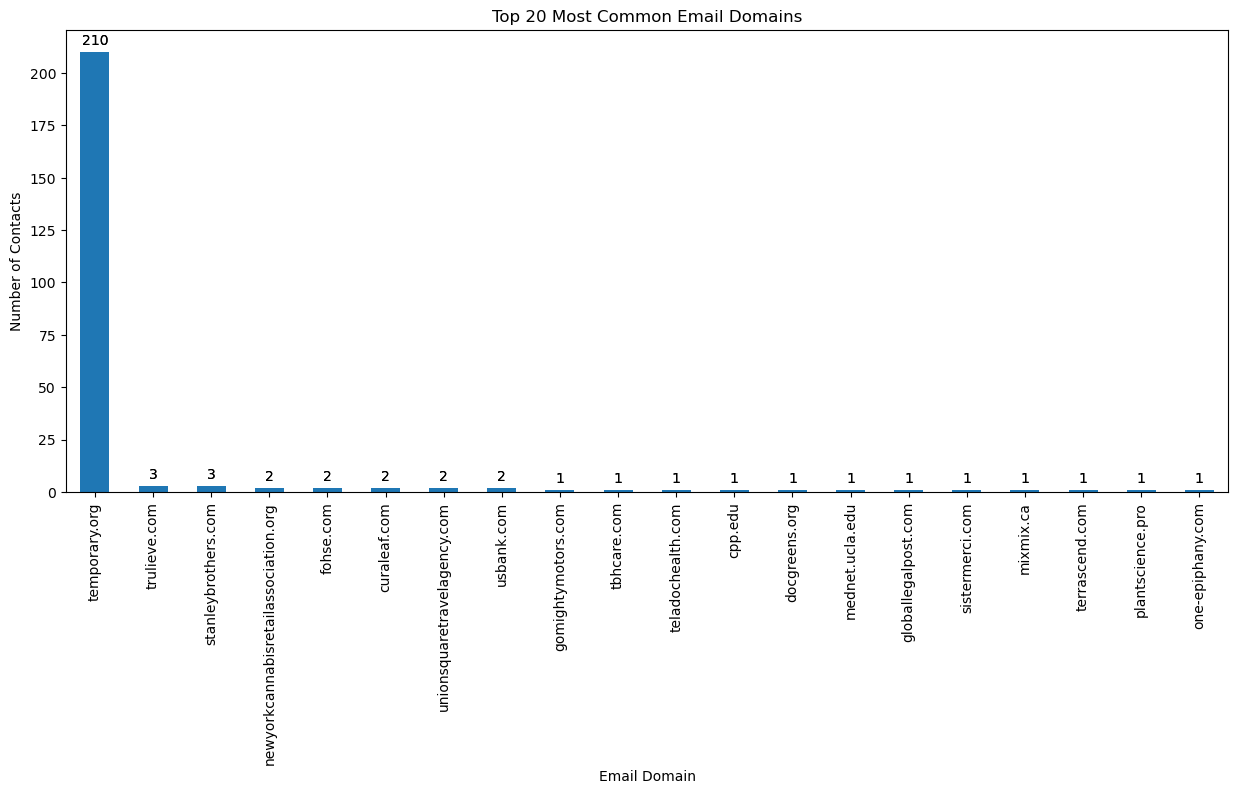

In [21]:
# Extract email domains
contacts_df_cleaned['email_domain'] = contacts_df_cleaned['email'].apply(lambda x: x.split('@')[1])

# Count the occurrences of each domain
domain_counts = contacts_df_cleaned['email_domain'].value_counts()

# Display the top 20 most common email domains
display_graph(domain_counts, 'Top 20 Most Common Email Domains', 'Email Domain', 'Number of Contacts', 15, True)

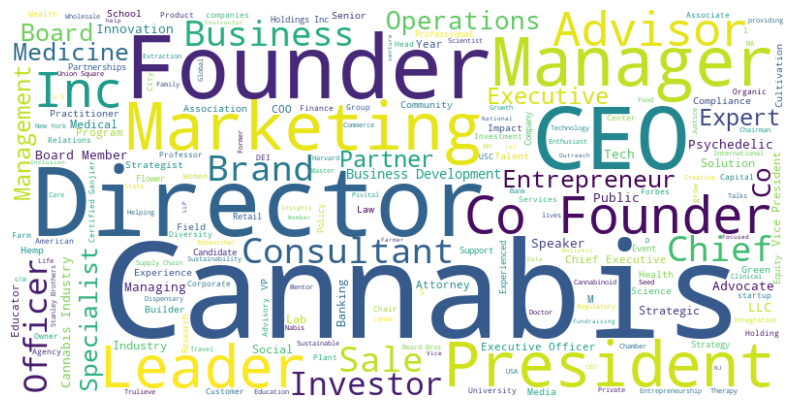

In [22]:
# Combine all descriptions into a single string
all_descriptions = ' '.join(contacts_df_cleaned['description'])

generate_word_cloud(all_descriptions)

# ----------------------------------------------------------------------------------------------------------------

# Contents Dataset

In [23]:
content_df = pd.read_csv(tsv_dict['content'], sep='\t')
content_df.rename(columns={' description': 'description'}, inplace=True)
content_df

,id,title,description,content_type,organisation_id,url,creator_id,created,publication_date
0,1,Justice Department Researcher Questions 0.3% T...,The 0.3 percent THC threshold in the federal d...,article,NaN,https://www.marijuanamoment.net/justice-depart...,1.0,1714286073,NaN
1,2,Cannabis operator Canopy raising $35 million i...,Canadian cannabis company Canopy Growth Corp. ...,article,NaN,https://mjbizdaily.com/cannabis-operator-canop...,1.0,1714286073,NaN
2,3,Global Cannabis Legalization: A Comprehensive ...,This article provides an overview of the evolv...,article,NaN,https://thecannabiswatcher.com/pages/articles/...,1.0,1714286073,NaN
3,4,Top Biden Health Official In Touch With DEA Ab...,The U.S. Department of Health and Human Servic...,article,NaN,https://www.marijuanamoment.net/top-biden-heal...,1.0,1714286073,NaN
4,5,Regulated marijuana offers new chance at equit...,"Martin Luther King III, co-founder of the Drum...",article,NaN,https://mjbizdaily.com/marijuana-social-equity...,1.0,1714286073,NaN
...,...,...,...,...,...,...,...,...,...
136,138,Auxly Cannabis inks tentative deal with lender...,Auxly Cannabis Group has signed a nonbinding t...,article,NaN,https://mjbizdaily.com/auxly-cannabis-inks-ten...,NaN,1715376400,"January 3, 2024"
137,139,Village Farms sends first cannabis shipment to...,Village Farms International has sent its first...,article,NaN,https://mjbizdaily.com/village-farms-sends-fir...,NaN,1715376400,"January 3, 2024"
138,140,Cannabis operators say they have little to sho...,With 23 state contracts for cannabis track-and...,article,NaN,https://mjbizdaily.com/cannabis-track-and-trac...,NaN,1715376400,"January 3, 2024"
139,141,"Trulieve Cannabis closes $25 million loan, hir...",Florida-based multistate operator Trulieve Can...,article,NaN,https://mjbizdaily.com/trulieve-cannabis-close...,NaN,1715376400,"January 2, 2024"


In [24]:
data_info(content_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                141 non-null    int64  
 1   title             141 non-null    object 
 2   description       141 non-null    object 
 3   content_type      141 non-null    object 
 4   organisation_id   0 non-null      float64
 5   url               141 non-null    object 
 6   creator_id        8 non-null      float64
 7   created           141 non-null    int64  
 8   publication_date  133 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 10.0+ KB
None
-----------------------------------------------------------------------------------------------------------------------------
columns
Index(['id', 'title', 'description', 'content_type', 'organisation_id', 'url',
       'creator_id', 'created', 'publication_date'],
      dtype='object')
------------------

In [25]:
# Drop columns with more than 50% missing values
content_df_cleaned = data_clean_up(content_df)
content_df_cleaned

id                    0
title                 0
description           0
content_type          0
organisation_id     141
url                   0
creator_id          133
created               0
publication_date      8
dtype: int64

columns with most of the values null
['organisation_id', 'creator_id']


,id,title,description,content_type,url,created,publication_date
0,1,Justice Department Researcher Questions 0.3% T...,The 0.3 percent THC threshold in the federal d...,article,https://www.marijuanamoment.net/justice-depart...,1714286073,NaN
1,2,Cannabis operator Canopy raising $35 million i...,Canadian cannabis company Canopy Growth Corp. ...,article,https://mjbizdaily.com/cannabis-operator-canop...,1714286073,NaN
2,3,Global Cannabis Legalization: A Comprehensive ...,This article provides an overview of the evolv...,article,https://thecannabiswatcher.com/pages/articles/...,1714286073,NaN
3,4,Top Biden Health Official In Touch With DEA Ab...,The U.S. Department of Health and Human Servic...,article,https://www.marijuanamoment.net/top-biden-heal...,1714286073,NaN
4,5,Regulated marijuana offers new chance at equit...,"Martin Luther King III, co-founder of the Drum...",article,https://mjbizdaily.com/marijuana-social-equity...,1714286073,NaN
...,...,...,...,...,...,...,...
136,138,Auxly Cannabis inks tentative deal with lender...,Auxly Cannabis Group has signed a nonbinding t...,article,https://mjbizdaily.com/auxly-cannabis-inks-ten...,1715376400,"January 3, 2024"
137,139,Village Farms sends first cannabis shipment to...,Village Farms International has sent its first...,article,https://mjbizdaily.com/village-farms-sends-fir...,1715376400,"January 3, 2024"
138,140,Cannabis operators say they have little to sho...,With 23 state contracts for cannabis track-and...,article,https://mjbizdaily.com/cannabis-track-and-trac...,1715376400,"January 3, 2024"
139,141,"Trulieve Cannabis closes $25 million loan, hir...",Florida-based multistate operator Trulieve Can...,article,https://mjbizdaily.com/trulieve-cannabis-close...,1715376400,"January 2, 2024"


In [26]:
numeric_stats, non_numeric_stats = column_stat(content_df_cleaned)

numeric_stats

,count,mean,std,min,25%,50%,75%,max
id,141.0,7.196454e+01,40.907109,1.000000e+00,3.700000e+01,7.200000e+01,1.070000e+02,1.420000e+02
created,141.0,1.715315e+09,253136.054420,1.714286e+09,1.715376e+09,1.715376e+09,1.715376e+09,1.715376e+09


In [27]:
non_numeric_stats

,count,unique,top,freq
title,141,141,Justice Department Researcher Questions 0.3% T...,1
description,141,141,The 0.3 percent THC threshold in the federal d...,1
content_type,141,1,article,141
url,141,141,https://www.marijuanamoment.net/justice-depart...,1
publication_date,133,63,"March 13, 2024",4


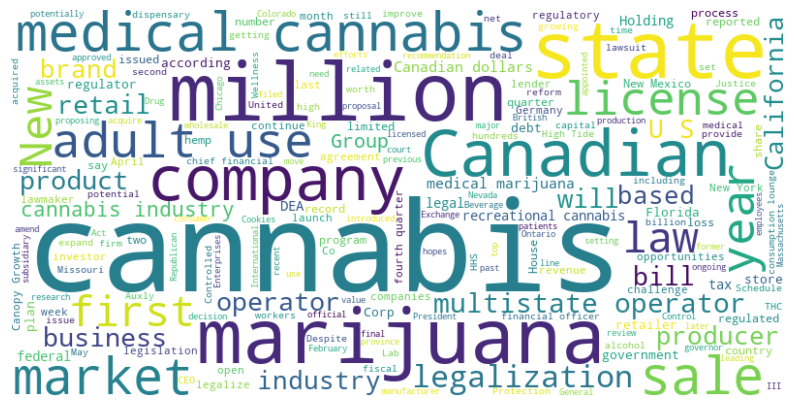

In [28]:
# Combine all descriptions into a single string
all_descriptions = ' '.join(content_df_cleaned['description'])

generate_word_cloud(all_descriptions)

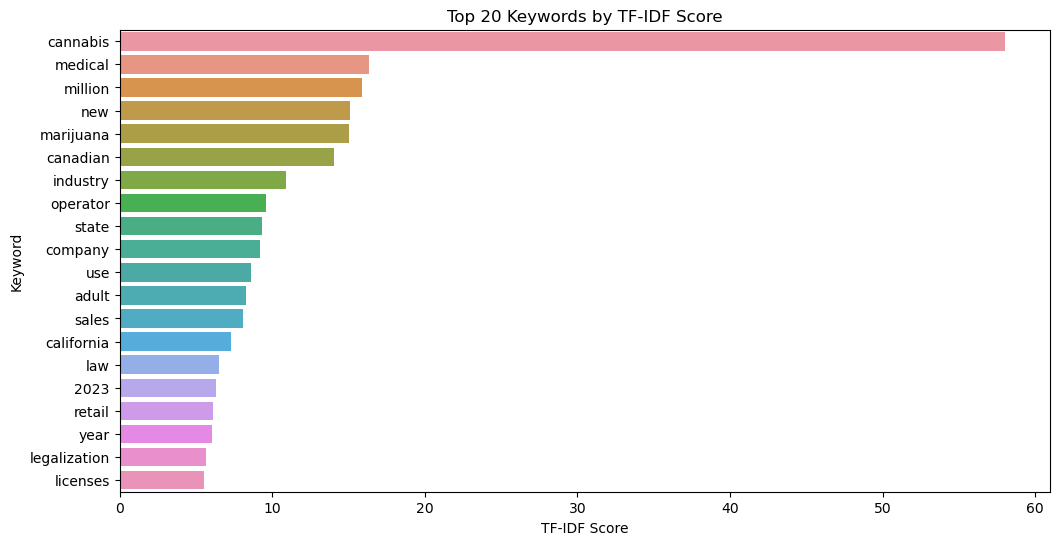

In [29]:
# Combine titles and descriptions into a single text field
content_df_cleaned['text'] = content_df_cleaned['title'] + " " + content_df_cleaned['description']

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = vectorizer.fit_transform(content_df_cleaned['text'])

# Get feature names and their respective TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)

# Create a DataFrame for TF-IDF scores
tfidf_df = pd.DataFrame({'feature': feature_names, 'tfidf_score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Plot TF-IDF scores
plt.figure(figsize=(12, 6))
sns.barplot(x=tfidf_df['tfidf_score'], y=tfidf_df['feature'])
plt.title('Top 20 Keywords by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Keyword')
plt.show()

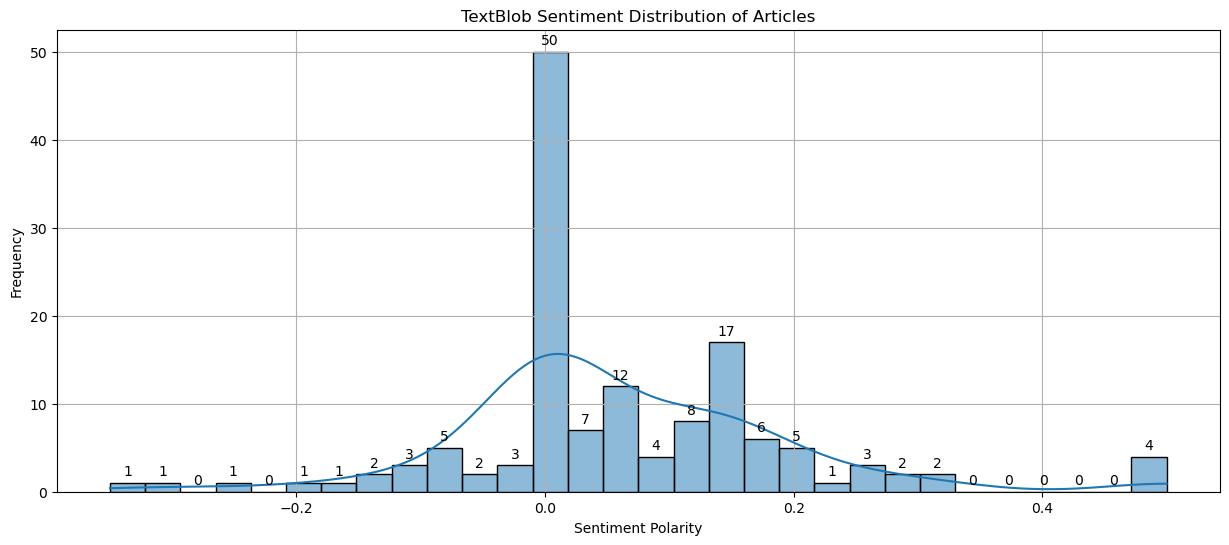

In [30]:
# Function to calculate sentiment using TextBlob
def get_advanced_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply TextBlob sentiment analysis on descriptions
content_df_cleaned['advanced_sentiment'] = content_df_cleaned['description'].apply(get_advanced_sentiment)

# Summary statistics of TextBlob sentiment
advanced_sentiment = content_df_cleaned['advanced_sentiment']

# Plot TextBlob sentiment distribution with counts
plot_sentiment_distribution(advanced_sentiment, 'TextBlob Sentiment Distribution of Articles', 'Sentiment Polarity', 'Frequency')

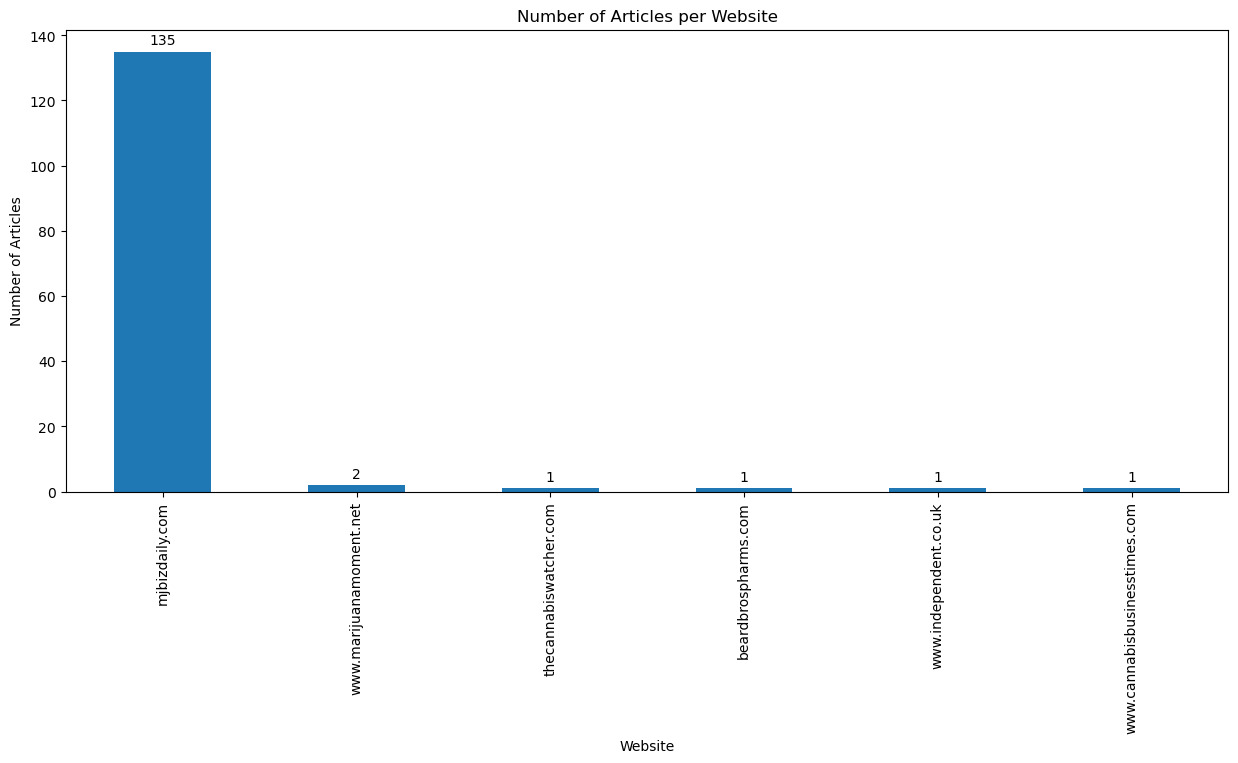

In [31]:
domain_count = content_df_cleaned['url'].apply(lambda x: urlparse(x).netloc).value_counts()

# Plot the distribution of articles per website
display_graph(domain_count, 'Number of Articles per Website', 'Website', 'Number of Articles', 15)

# ----------------------------------------------------------------------------------------------------------------

# Events

In [32]:
events_df = pd.read_csv(tsv_dict['events'], sep='\t')
events_df

,id,title,event_type,description,start,end,location,url,price,organisation_id,created,last_modified,lon,lat
0,1,2024 Cannabis Research Conference,conferences,The 8th annual Cannabis Research Conference (C...,1723017600,1723219200,"Fort Collins, CO",https://www.eventbrite.com/e/2024-cannabis-res...,NaN,NaN,1.711441e+09,1.714920e+09,-105.077011,40.587178
1,2,2024 HBS Cannabis Business Conference,conferences,Join us for a scholarly discussion of the cann...,1713639600,1713715200,"Boston, MA",https://www.eventbrite.com.au/e/2024-hbs-canna...,From $25.00,NaN,1.711441e+09,1.714920e+09,-71.060511,42.355433
2,3,"Ohio Cannabis Session, March 30, 2024",conferences,Training Coursework:,1711792800,1711803600,"Toledo, OH",https://www.eventbrite.com/e/ohio-cannabis-ses...,Free,NaN,1.711441e+09,1.714920e+09,-83.537817,41.652914
3,4,3rd Annual Higher Learning: Cannabis Conferenc...,conferences,NaN,1713610800,1713625200,"New York, NY",https://www.eventbrite.com/e/3rd-annual-higher...,NaN,NaN,1.711441e+09,1.714920e+09,-74.006015,40.712728
4,5,Accelerate Cannabis: The Mid-Atlantic Mixer,conferences,Hard Rock Hotel & Casino Atlantic City,1704299400,1704299400,"Atlantic City, NJ",https://www.eventbrite.com/e/accelerate-cannab...,NaN,NaN,1.711441e+09,1.714920e+09,-74.422935,39.364285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1252,How to Capitalize on Emerging Trends in the Le...,webinar,Industry observers provide important insights ...,0,0,online,https://www.cannabisbusinesstimes.com/media/he...,free,NaN,1.715368e+09,NaN,NaN,NaN
262,1253,Fluence by OSRAM: Adjusting Your Environment ...,webinar,"Sean Sangster, horticulture specialist with Fl...",0,0,online,https://www.cannabisbusinesstimes.com/media/we...,free,NaN,1.715368e+09,NaN,NaN,NaN
263,1254,Supporting the Cannabis Industry with Industry...,webinar,"Neil Coole, Director - Food & Retail for BSI A...",0,0,online,https://www.cannabisbusinesstimes.com/media/ca...,free,NaN,1.715368e+09,NaN,NaN,NaN
264,1255,When It's Time to Terminate Your Cannabis Empl...,webinar,Learn how to identify and address problems bef...,0,0,online,https://www.cannabisbusinesstimes.com/media/le...,free,NaN,1.715368e+09,NaN,NaN,NaN


In [33]:
data_info(events_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               266 non-null    int64  
 1   title            266 non-null    object 
 2   event_type       266 non-null    object 
 3   description      262 non-null    object 
 4   start            259 non-null    object 
 5   end              259 non-null    object 
 6   location         266 non-null    object 
 7   url              265 non-null    object 
 8   price            183 non-null    object 
 9   organisation_id  1 non-null      float64
 10  created          266 non-null    float64
 11  last_modified    187 non-null    float64
 12  lon              185 non-null    float64
 13  lat              185 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 29.2+ KB
None
--------------------------------------------------------------------------------------

In [34]:
# Drop columns with more than 50% missing values
events_df_cleaned = data_clean_up(events_df)

id                   0
title                0
event_type           0
description          4
start                7
end                  7
location             0
url                  1
price               83
organisation_id    265
created              0
last_modified       79
lon                 81
lat                 81
dtype: int64

columns with most of the values null
['organisation_id']


In [35]:
# For 'description', 'start', 'end', 'url', 'price', 'last_modified', 'lon', 'lat' we will fill missing values accordingly
events_df_cleaned = events_df_cleaned.fillna({
    'title': 'No Title',
    'event_type': 'Unknown',
    'description': 'No Description',
    'start': 0,
    'end': 0,
    'location': 'No Location',
    'url': 'No URL',
    'price': 'Not Available',
    'organisation_id': 0,
    'created': 0,
    'last_modified': 0,
    'lon': 0.0,
    'lat': 0.0
})
events_df_cleaned['price'] = events_df_cleaned['price'].str.capitalize()

In [36]:
events_df_cleaned

,id,title,event_type,description,start,end,location,url,price,created,last_modified,lon,lat
0,1,2024 Cannabis Research Conference,conferences,The 8th annual Cannabis Research Conference (C...,1723017600,1723219200,"Fort Collins, CO",https://www.eventbrite.com/e/2024-cannabis-res...,Not available,1.711441e+09,1.714920e+09,-105.077011,40.587178
1,2,2024 HBS Cannabis Business Conference,conferences,Join us for a scholarly discussion of the cann...,1713639600,1713715200,"Boston, MA",https://www.eventbrite.com.au/e/2024-hbs-canna...,From $25.00,1.711441e+09,1.714920e+09,-71.060511,42.355433
2,3,"Ohio Cannabis Session, March 30, 2024",conferences,Training Coursework:,1711792800,1711803600,"Toledo, OH",https://www.eventbrite.com/e/ohio-cannabis-ses...,Free,1.711441e+09,1.714920e+09,-83.537817,41.652914
3,4,3rd Annual Higher Learning: Cannabis Conferenc...,conferences,No Description,1713610800,1713625200,"New York, NY",https://www.eventbrite.com/e/3rd-annual-higher...,Not available,1.711441e+09,1.714920e+09,-74.006015,40.712728
4,5,Accelerate Cannabis: The Mid-Atlantic Mixer,conferences,Hard Rock Hotel & Casino Atlantic City,1704299400,1704299400,"Atlantic City, NJ",https://www.eventbrite.com/e/accelerate-cannab...,Not available,1.711441e+09,1.714920e+09,-74.422935,39.364285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,1252,How to Capitalize on Emerging Trends in the Le...,webinar,Industry observers provide important insights ...,0,0,online,https://www.cannabisbusinesstimes.com/media/he...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000
262,1253,Fluence by OSRAM: Adjusting Your Environment ...,webinar,"Sean Sangster, horticulture specialist with Fl...",0,0,online,https://www.cannabisbusinesstimes.com/media/we...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000
263,1254,Supporting the Cannabis Industry with Industry...,webinar,"Neil Coole, Director - Food & Retail for BSI A...",0,0,online,https://www.cannabisbusinesstimes.com/media/ca...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000
264,1255,When It's Time to Terminate Your Cannabis Empl...,webinar,Learn how to identify and address problems bef...,0,0,online,https://www.cannabisbusinesstimes.com/media/le...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000


In [37]:
numeric_stats, non_numeric_stats = column_stat(events_df_cleaned)

numeric_stats

,count,mean,std,min,25%,50%,75%,max
id,266.0,7.530000e+02,4.421557e+02,1.000000,3.815000e+02,8.435000e+02,1.189750e+03,1.256000e+03
created,266.0,1.707178e+09,1.050824e+08,-74.451817,1.711441e+09,1.714066e+09,1.715368e+09,1.715368e+09
last_modified,266.0,1.199157e+09,7.879209e+08,0.000000,0.000000e+00,1.714921e+09,1.714923e+09,1.714937e+09
lon,266.0,-6.263753e+01,4.367620e+01,-124.015952,-9.019102e+01,-7.703654e+01,0.000000e+00,0.000000e+00
lat,266.0,2.578637e+01,1.761462e+01,0.000000,0.000000e+00,3.401947e+01,3.976106e+01,4.497730e+01


In [38]:
non_numeric_stats

,count,unique,top,freq
title,266,235,Sound Healing with The Singing Bowl Lady,8
event_type,266,7,webinar,79
description,266,230,Join us in this powerful immersion into the to...,8
start,266,153,0,79
end,266,158,0,79
location,266,106,online,79
url,266,266,https://www.eventbrite.com/e/2024-cannabis-res...,1
price,266,19,Free,144


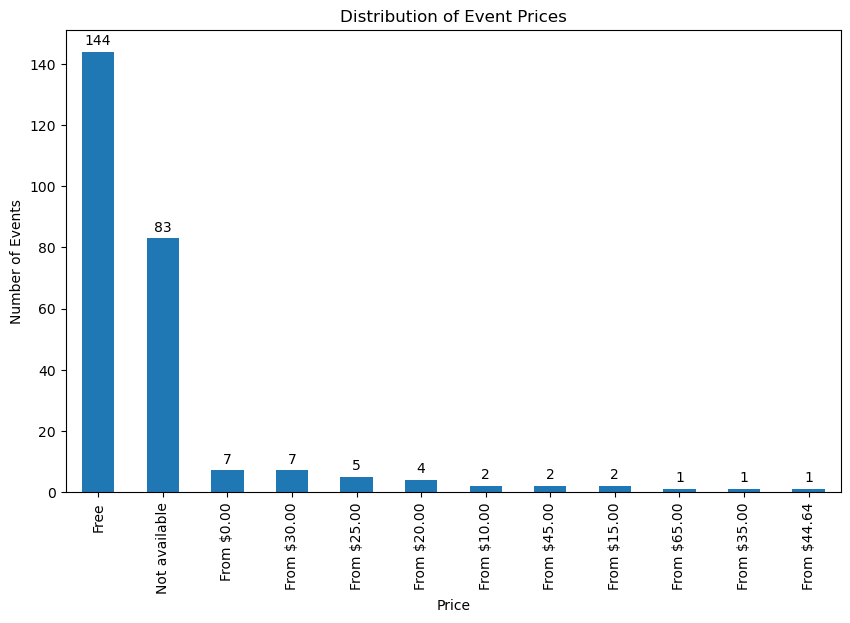

In [39]:
price_counts_capitalized = events_df_cleaned['price'].value_counts()

display_graph(price_counts_capitalized.head(12), 'Distribution of Event Prices', 'Price', 'Number of Events', 10)

C:\Users\dhyan\AppData\Local\Temp\ipykernel_9332\167072827.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  events_df_cleaned['start'] = pd.to_datetime(events_df_cleaned['start'], unit='s')
C:\Users\dhyan\AppData\Local\Temp\ipykernel_9332\167072827.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  events_df_cleaned['end'] = pd.to_datetime(events_df_cleaned['end'], unit='s')


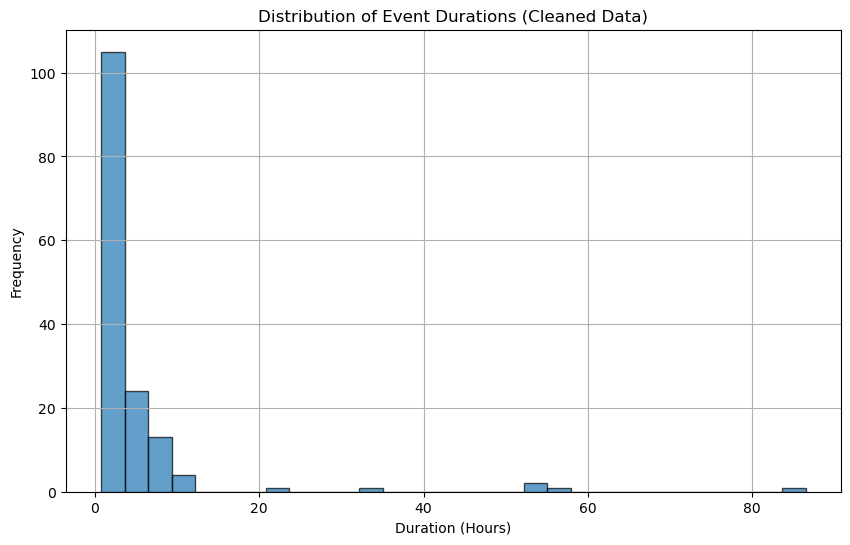

In [40]:
# Delete rows where 'start' and 'end' columns contain non-numeric values
events_df_cleaned = events_df_cleaned[pd.to_numeric(events_df_cleaned['start'], errors='coerce').notnull()]
events_df_cleaned = events_df_cleaned[pd.to_numeric(events_df_cleaned['end'], errors='coerce').notnull()]

# Convert 'start' and 'end' columns to datetime again
events_df_cleaned['start'] = pd.to_datetime(events_df_cleaned['start'], unit='s')
events_df_cleaned['end'] = pd.to_datetime(events_df_cleaned['end'], unit='s')

# Recalculate event duration in hours
events_df_cleaned['duration'] = (events_df_cleaned['end'] - events_df_cleaned['start']).dt.total_seconds() / 3600

events_duration = events_df_cleaned[events_df_cleaned['duration'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(events_duration['duration'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Event Durations (Cleaned Data)')
plt.xlabel('Duration (Hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

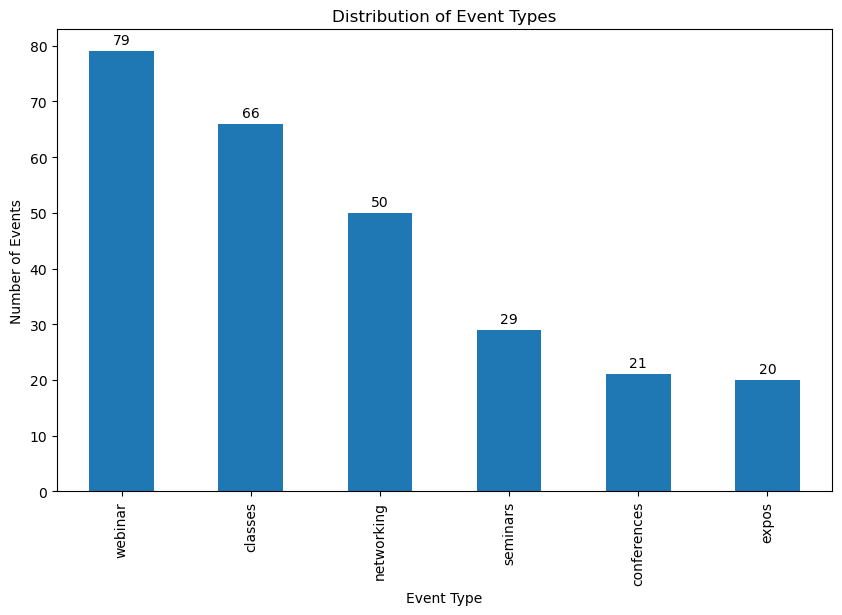

In [41]:
event_type_counts = events_df_cleaned['event_type'].value_counts()

display_graph(event_type_counts, 'Distribution of Event Types', 'Event Type', 'Number of Events', 10)

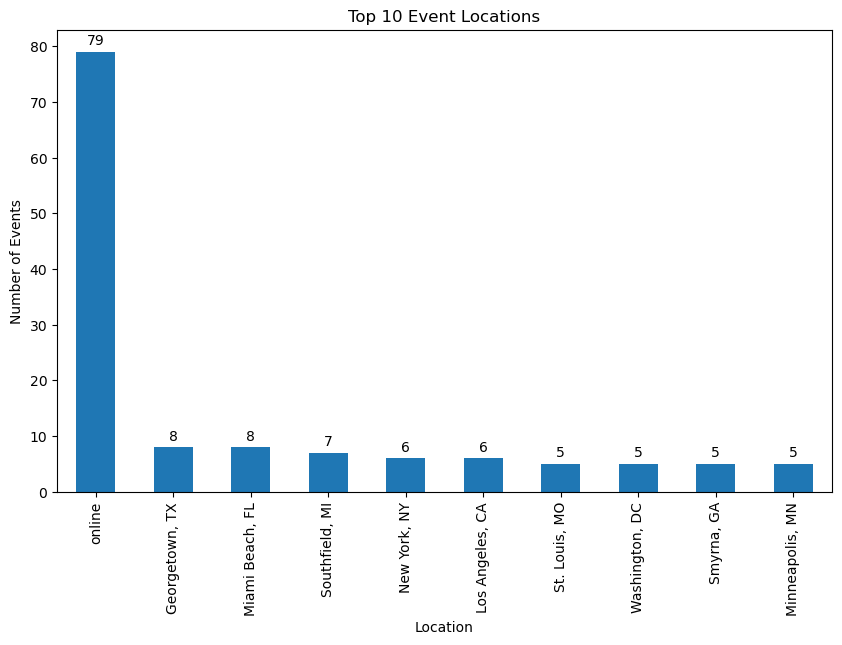

In [42]:
location_counts = events_df_cleaned['location'].value_counts().head(10)

display_graph(location_counts, 'Top 10 Event Locations', 'Location', 'Number of Events', 10)

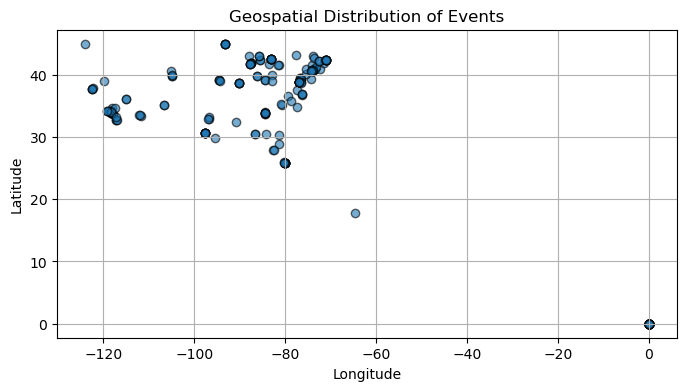

In [43]:
# Plotting the geospatial distribution of events based on latitude and longitude
plt.figure(figsize=(8, 4))
plt.scatter(events_df_cleaned['lon'], events_df_cleaned['lat'], alpha=0.6, edgecolor='k')
plt.title('Geospatial Distribution of Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [44]:
import folium
from folium.plugins import MarkerCluster

# Create a base map
map_center = [events_df_cleaned['lat'].mean(), events_df_cleaned['lon'].mean()]
event_map = folium.Map(location=map_center, zoom_start=5)

# Add marker cluster to the map
marker_cluster = MarkerCluster().add_to(event_map)

# Add points to the marker cluster
for idx, row in events_df_cleaned.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], 
                  popup=f"{row['title']}<br>{row['location']}").add_to(marker_cluster)

# Save the map to an HTML file
map_path = '../Dataset/event_map.html'
event_map.save(map_path)

map_path

'../Dataset/event_map.html'

# ----------------------------------------------------------------------------------------------------------------

# Organisations

In [45]:
organisations_df = pd.read_csv(tsv_dict['organisations'], sep='\t')
organisations_df

,id,name,city,state,country,industry,profile,created,description,linkedin_url,phone_number,email,year_founded,logo_name
0,1,NACB,San Francisco,CA,United States,Networking,"{""needs"": [ ""Health Benefits"", ""Supply Chain ...",1710004784,National Association of Cannabis Businesses,NaN,NaN,NaN,NaN,nacb_royal_blue_option2.png
1,18,Element Apothec,Los Angeles,CA,United States,Retail,"{""needs"": [""Community Activation"", ""Community ...",1714143150,Retail Health and Personal Care Products,NaN,NaN,NaN,NaN,element_apothec.png
2,19,iFreshly,Austin,TX,United States,Marketing,"{""needs"": [""Business Support"", ""Strategy Audit...",1714143150,"Fractional CMO services, mainly servicing cann...",NaN,NaN,NaN,NaN,united_core_alliance.png
3,20,Rooted Intellect,Westminster,CO,United States,E-Commerce,"{""needs"": [""Business Support"", ""Strategy Audit...",1714143150,Revolutionizing Your Grow Experience,NaN,NaN,NaN,NaN,off_the_charts.png
4,21,GreenSpace Pro,Denver,CO,United States,DMS,"{""needs"": [""Communication Strategy"", ""Target A...",1714143150,The Document + Data Management Tool For Growin...,NaN,NaN,NaN,NaN,green_space_pro.png
5,22,420 CPAs,Los Angeles,CA,United States,Accounting,"{""needs"": [""Communication Strategy"", ""Expertis...",1714143150,CPA and fractional CFO services for the cannab...,NaN,NaN,NaN,NaN,420_cpa.png
6,23,Hoodie Analytics,Aliso Viejo,CA,United States,Business Analytics,"{""needs"": [""Communications Strategy"", ""Experti...",1714143150,Real-time Cannabis Product Assortment & Pricin...,NaN,NaN,NaN,NaN,hoodie_analytics.png
7,24,Off the Charts,NaN,CA,United States,Retail,"{""needs"": [""Community Activation"", ""Community ...",1714143150,Cannabis Dispensaries offering the best shoppi...,NaN,NaN,NaN,NaN,nabcl.png
8,25,The Greenbelt Group,Los Angeles,CA,United States,Consultancy,"{""needs"": [""Communication Strategy"", ""Target A...",1714143150,Boutique Consulting Group dedicated to help ca...,NaN,NaN,NaN,NaN,the_greenbelt_group.png
9,26,Clique MJ,NaN,CA,United States,E-Commerce,"{""needs"": [""Fundraising"", ""Grant Applications""...",1714143150,AI Powered Rewards Program for Brands,NaN,NaN,NaN,NaN,clique_mj.png


In [46]:
data_info(organisations_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19 non-null     int64  
 1   name          19 non-null     object 
 2   city          16 non-null     object 
 3   state         19 non-null     object 
 4   country       19 non-null     object 
 5   industry      19 non-null     object 
 6   profile       19 non-null     object 
 7   created       19 non-null     int64  
 8   description   19 non-null     object 
 9   linkedin_url  0 non-null      float64
 10  phone_number  0 non-null      float64
 11  email         0 non-null      float64
 12  year_founded  0 non-null      float64
 13  logo_name     19 non-null     object 
dtypes: float64(4), int64(2), object(8)
memory usage: 2.2+ KB
None
-----------------------------------------------------------------------------------------------------------------------------
columns
Ind

In [47]:
# Drop columns with more than 50% missing values
organisations_df_cleaned = data_clean_up(organisations_df)

id               0
name             0
city             3
state            0
country          0
industry         0
profile          0
created          0
description      0
linkedin_url    19
phone_number    19
email           19
year_founded    19
logo_name        0
dtype: int64

columns with most of the values null
['linkedin_url', 'phone_number', 'email', 'year_founded']


In [48]:
# Fill missing values in 'city' with 'Unknown'
organisations_df_cleaned['city'].fillna('Unknown', inplace=True)

In [49]:
organisations_df_cleaned

,id,name,city,state,country,industry,profile,created,description,logo_name
0,1,NACB,San Francisco,CA,United States,Networking,"{""needs"": [ ""Health Benefits"", ""Supply Chain ...",1710004784,National Association of Cannabis Businesses,nacb_royal_blue_option2.png
1,18,Element Apothec,Los Angeles,CA,United States,Retail,"{""needs"": [""Community Activation"", ""Community ...",1714143150,Retail Health and Personal Care Products,element_apothec.png
2,19,iFreshly,Austin,TX,United States,Marketing,"{""needs"": [""Business Support"", ""Strategy Audit...",1714143150,"Fractional CMO services, mainly servicing cann...",united_core_alliance.png
3,20,Rooted Intellect,Westminster,CO,United States,E-Commerce,"{""needs"": [""Business Support"", ""Strategy Audit...",1714143150,Revolutionizing Your Grow Experience,off_the_charts.png
4,21,GreenSpace Pro,Denver,CO,United States,DMS,"{""needs"": [""Communication Strategy"", ""Target A...",1714143150,The Document + Data Management Tool For Growin...,green_space_pro.png
5,22,420 CPAs,Los Angeles,CA,United States,Accounting,"{""needs"": [""Communication Strategy"", ""Expertis...",1714143150,CPA and fractional CFO services for the cannab...,420_cpa.png
6,23,Hoodie Analytics,Aliso Viejo,CA,United States,Business Analytics,"{""needs"": [""Communications Strategy"", ""Experti...",1714143150,Real-time Cannabis Product Assortment & Pricin...,hoodie_analytics.png
7,24,Off the Charts,Unknown,CA,United States,Retail,"{""needs"": [""Community Activation"", ""Community ...",1714143150,Cannabis Dispensaries offering the best shoppi...,nabcl.png
8,25,The Greenbelt Group,Los Angeles,CA,United States,Consultancy,"{""needs"": [""Communication Strategy"", ""Target A...",1714143150,Boutique Consulting Group dedicated to help ca...,the_greenbelt_group.png
9,26,Clique MJ,Unknown,CA,United States,E-Commerce,"{""needs"": [""Fundraising"", ""Grant Applications""...",1714143150,AI Powered Rewards Program for Brands,clique_mj.png


In [50]:
numeric_stats, non_numeric_stats = column_stat(organisations_df_cleaned)

numeric_stats

,count,mean,std,min,25%,50%,75%,max
id,19.0,2.542105e+01,8.105662,1.000000e+00,2.150000e+01,2.600000e+01,3.100000e+01,3.600000e+01
created,19.0,1.713925e+09,949406.272915,1.710005e+09,1.714143e+09,1.714143e+09,1.714143e+09,1.714143e+09


In [51]:
non_numeric_stats

,count,unique,top,freq
name,19,19,NACB,1
city,19,12,Los Angeles,5
state,19,5,CA,13
country,19,1,United States,19
industry,19,14,Networking,2
profile,19,19,"{""needs"": [ ""Health Benefits"", ""Supply Chain ...",1
description,19,19,National Association of Cannabis Businesses,1
logo_name,19,19,nacb_royal_blue_option2.png,1


In [52]:
import json

# Extract needs from the profile column
organisations_df_cleaned['needs'] = organisations_df_cleaned['profile'].apply(lambda x: json.loads(x).get('needs', []))

# Flatten the list of needs and calculate the frequency of each need
all_needs = organisations_df_cleaned['needs'].explode().value_counts()
all_needs

needs
Business Support                                            12
Industry Analysis Service                                   11
User Acquisition                                            11
Audience Analysis Service                                   11
Market Expansion Strategy                                   11
                                                            ..
Customer Service and Retention Strategy Service              1
Communication of Policy Positions                            1
 Bussines support solutions                                  1
Communication Strategy through/ Leadership NACB Solution     1
Operational Efficiency Measures                              1
Name: count, Length: 138, dtype: int64

In [53]:
# Analyze the distribution of organisations by country
country_distribution = get_distribution(organisations_df_cleaned, 'country')

# Analyze the distribution of organisations by state
state_distribution = get_distribution(organisations_df_cleaned, 'state')

# Analyze the distribution of organisations by city
city_distribution = get_distribution(organisations_df_cleaned, 'city')

# Analyze the distribution of organisations by industry
industry_distribution = get_distribution(organisations_df_cleaned, 'industry')

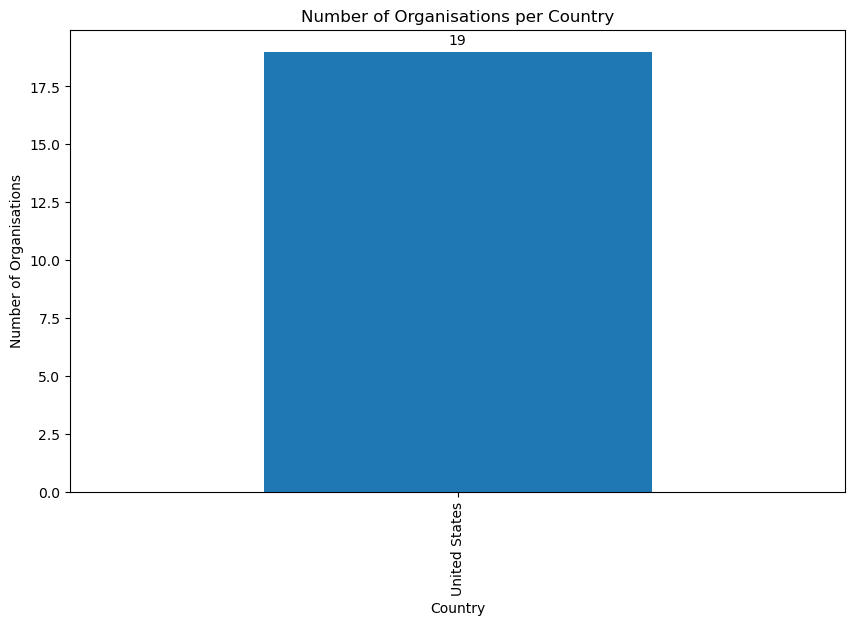

In [54]:
# Bar chart for country distribution with labels
display_graph(country_distribution, 'Number of Organisations per Country', 'Country', 'Number of Organisations', 10)

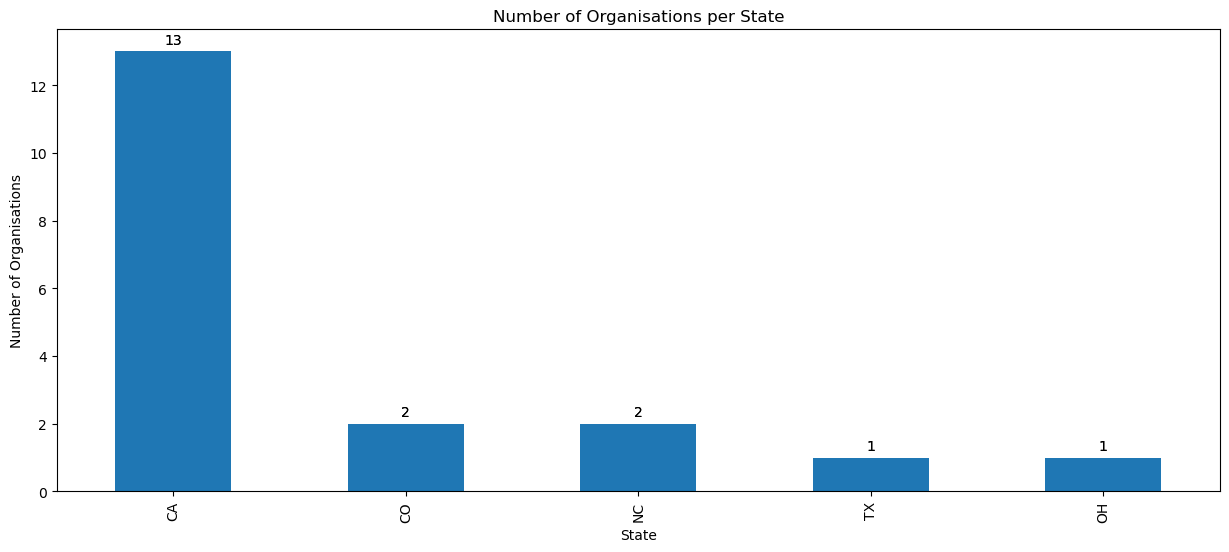

In [55]:
# Bar chart for state distribution with labels
display_graph(state_distribution, 'Number of Organisations per State', 'State', 'Number of Organisations', 15, True)

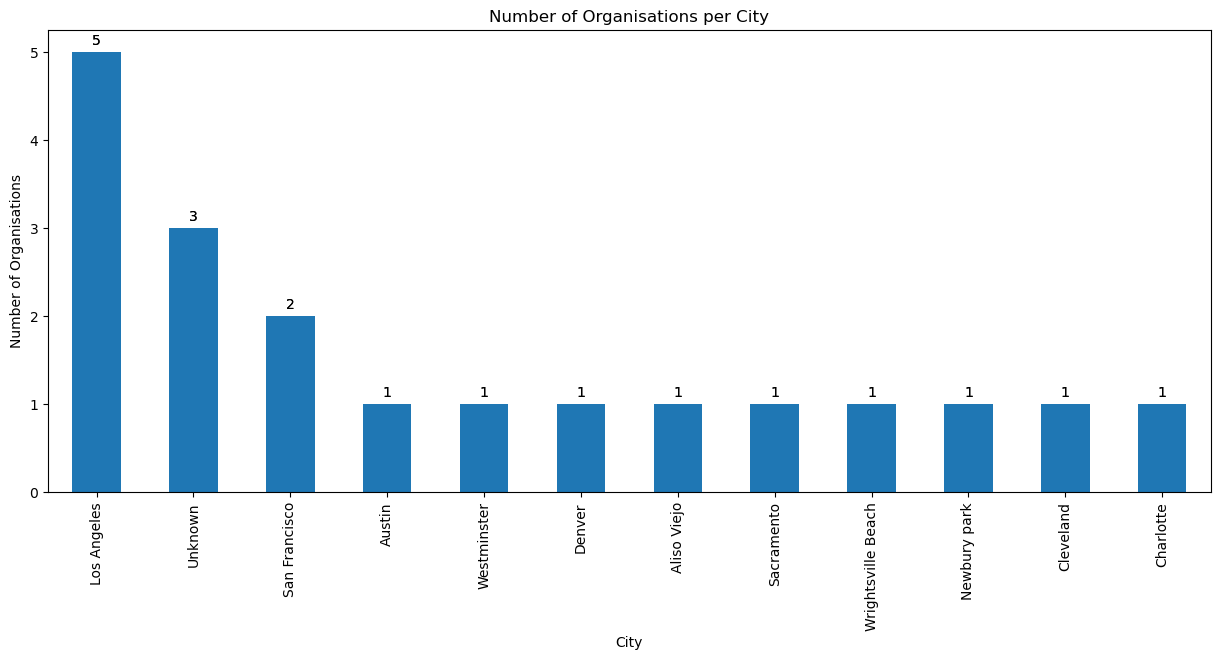

In [56]:
# Bar chart for city distribution with labels
display_graph(city_distribution, 'Number of Organisations per City', 'City', 'Number of Organisations', 15, True)

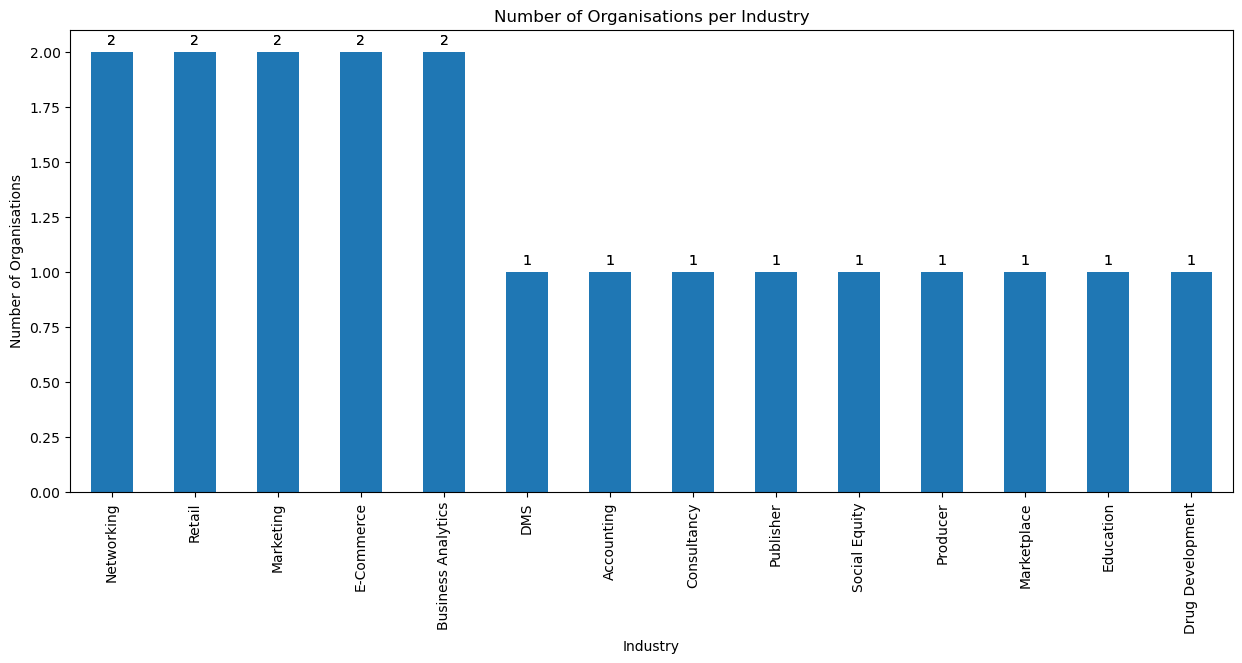

In [57]:
# Bar chart for industry distribution with labels
display_graph(industry_distribution, 'Number of Organisations per Industry', 'Industry', 'Number of Organisations', 15, True)

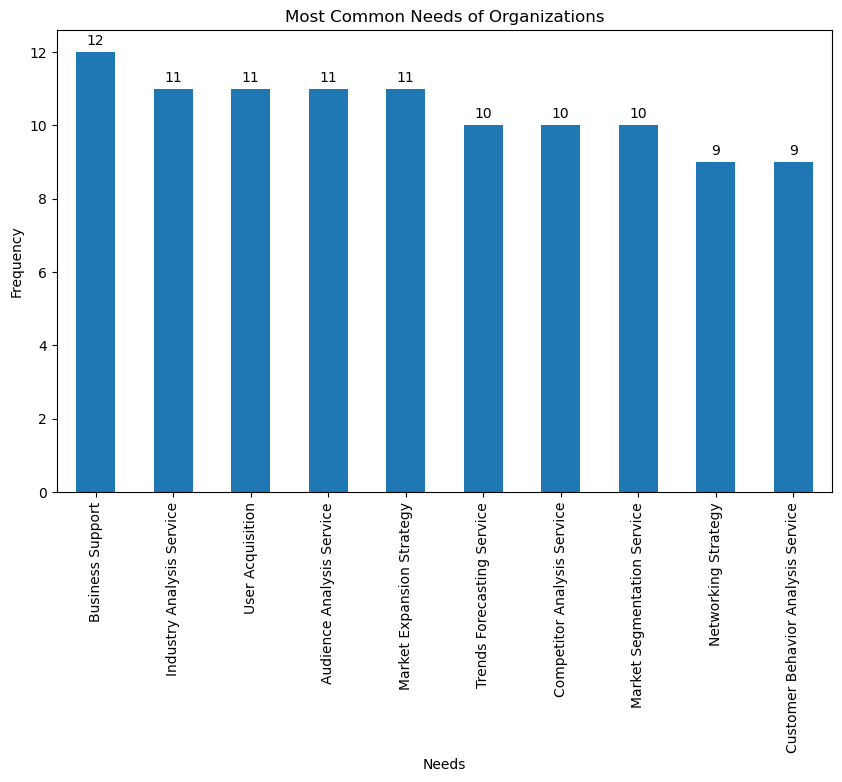

In [58]:
# Bar chart for industry distribution with labels
display_graph(all_needs.head(10), 'Most Common Needs of Organizations', 'Needs', 'Frequency', 10)

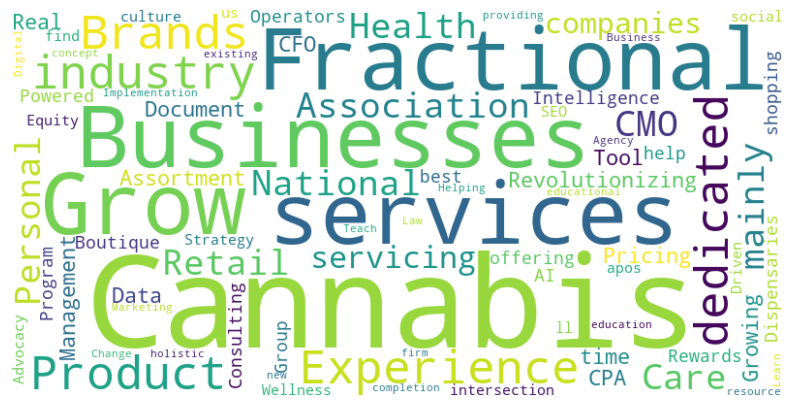

In [59]:
# Combine all descriptions into a single string
all_descriptions = ' '.join(organisations_df_cleaned['description'])

generate_word_cloud(all_descriptions)

# ----------------------------------------------------------------------------------------------------------------

# Recommendations

In [60]:
recommendations_df = pd.read_csv(tsv_dict['recommendations'], sep='\t')
recommendations_df

,id,title,asset_type,asset_id,organisation_id,user_id,creator_id,system_score,user_score,created,opened,deleted,saved,clicked_out
0,1,AFC Gamma is looking to finance unburdened can...,content,95,1,98,143,0.31,NaN,1715376481,1.715384e+09,1.715391e+09,NaN,1.715387e+09
1,2,Massachusetts cannabis regulator expanding sec...,content,71,1,98,98,0.30,NaN,1715376481,1.715384e+09,NaN,1.715387e+09,NaN
2,3,Institutional investor puts $50 million into c...,content,14,1,98,99,0.29,NaN,1715376481,1.715380e+09,1.715384e+09,NaN,NaN
3,4,AFC Gamma provides $34 million to Sunburn Cann...,content,69,1,98,144,0.28,NaN,1715376481,1.715384e+09,1.715387e+09,NaN,NaN
4,5,Cannabis operator Canopy raising $35 million i...,content,2,1,98,98,0.27,NaN,1715376481,1.715384e+09,1.715387e+09,1.715380e+09,1.715384e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,654,Agrify: From Flower to Diamonds How to Use Te...,event,1194,36,142,98,0.47,NaN,1715376724,1.715384e+09,NaN,NaN,NaN
654,655,Surna: What to Expect When You're Expanding or...,event,1245,36,142,99,0.44,NaN,1715376724,1.715380e+09,NaN,1.715381e+09,NaN
655,656,Agrify: From Flower to Diamonds How to Use Te...,event,1192,36,142,98,0.44,NaN,1715376724,1.715380e+09,1.715384e+09,1.715381e+09,1.715384e+09
656,657,Supporting the Cannabis Industry with Industry...,event,1254,36,142,144,0.43,NaN,1715376724,1.715384e+09,NaN,NaN,1.715388e+09


In [61]:
data_info(recommendations_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               658 non-null    int64  
 1   title            658 non-null    object 
 2   asset_type       658 non-null    object 
 3   asset_id         658 non-null    int64  
 4   organisation_id  658 non-null    int64  
 5   user_id          658 non-null    int64  
 6   creator_id       658 non-null    int64  
 7   system_score     658 non-null    float64
 8   user_score       0 non-null      float64
 9   created          658 non-null    int64  
 10  opened           625 non-null    float64
 11  deleted          403 non-null    float64
 12  saved            338 non-null    float64
 13  clicked_out      414 non-null    float64
dtypes: float64(6), int64(6), object(2)
memory usage: 72.1+ KB
None
--------------------------------------------------------------------------------------

In [62]:
# Drop columns with more than 50% missing values
recommendations_df_cleaned = data_clean_up(recommendations_df)

id                   0
title                0
asset_type           0
asset_id             0
organisation_id      0
user_id              0
creator_id           0
system_score         0
user_score         658
created              0
opened              33
deleted            255
saved              320
clicked_out        244
dtype: int64

columns with most of the values null
['user_score']


In [63]:
numeric_stats, non_numeric_stats = column_stat(recommendations_df_cleaned)

numeric_stats

,count,mean,std,min,25%,50%,75%,max
id,658.0,3.295000e+02,190.092521,1.000000e+00,1.652500e+02,3.295000e+02,4.937500e+02,6.580000e+02
asset_id,658.0,4.665350e+02,439.899223,2.000000e+00,9.600000e+01,3.860000e+02,5.855000e+02,1.256000e+03
organisation_id,658.0,2.417173e+01,8.907917,1.000000e+00,2.100000e+01,2.500000e+01,3.000000e+01,3.600000e+01
user_id,658.0,1.195061e+02,14.142915,9.600000e+01,1.072500e+02,1.180000e+02,1.330000e+02,1.440000e+02
creator_id,658.0,1.216520e+02,22.522348,9.800000e+01,9.800000e+01,1.430000e+02,1.430000e+02,1.440000e+02
system_score,658.0,4.117933e-01,0.101418,2.500000e-01,3.100000e-01,4.000000e-01,4.900000e-01,6.400000e-01
created,658.0,1.715377e+09,73.957030,1.715376e+09,1.715377e+09,1.715377e+09,1.715377e+09,1.715377e+09
opened,625.0,1.715383e+09,1613.158723,1.715380e+09,1.715380e+09,1.715384e+09,1.715384e+09,1.715384e+09
deleted,403.0,1.715386e+09,4629.693355,1.715380e+09,1.715384e+09,1.715384e+09,1.715391e+09,1.715395e+09
saved,338.0,1.715383e+09,3430.181954,1.715380e+09,1.715380e+09,1.715381e+09,1.715387e+09,1.715388e+09


In [64]:
non_numeric_stats

,count,unique,top,freq
title,658,75,Gabrielle Feldman | Program Manager for the En...,40
asset_type,658,3,contact,220


In [65]:
recommendations_df_cleaned

,id,title,asset_type,asset_id,organisation_id,user_id,creator_id,system_score,created,opened,deleted,saved,clicked_out
0,1,AFC Gamma is looking to finance unburdened can...,content,95,1,98,143,0.31,1715376481,1.715384e+09,1.715391e+09,NaN,1.715387e+09
1,2,Massachusetts cannabis regulator expanding sec...,content,71,1,98,98,0.30,1715376481,1.715384e+09,NaN,1.715387e+09,NaN
2,3,Institutional investor puts $50 million into c...,content,14,1,98,99,0.29,1715376481,1.715380e+09,1.715384e+09,NaN,NaN
3,4,AFC Gamma provides $34 million to Sunburn Cann...,content,69,1,98,144,0.28,1715376481,1.715384e+09,1.715387e+09,NaN,NaN
4,5,Cannabis operator Canopy raising $35 million i...,content,2,1,98,98,0.27,1715376481,1.715384e+09,1.715387e+09,1.715380e+09,1.715384e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,654,Agrify: From Flower to Diamonds How to Use Te...,event,1194,36,142,98,0.47,1715376724,1.715384e+09,NaN,NaN,NaN
654,655,Surna: What to Expect When You're Expanding or...,event,1245,36,142,99,0.44,1715376724,1.715380e+09,NaN,1.715381e+09,NaN
655,656,Agrify: From Flower to Diamonds How to Use Te...,event,1192,36,142,98,0.44,1715376724,1.715380e+09,1.715384e+09,1.715381e+09,1.715384e+09
656,657,Supporting the Cannabis Industry with Industry...,event,1254,36,142,144,0.43,1715376724,1.715384e+09,NaN,NaN,1.715388e+09


In [114]:
# Perform analysis
# Example analysis: Count of recommendations by asset_type
recommendation_counts = recommendations_df_cleaned['asset_type'].value_counts()
print("Recommendation Counts by Asset Type")
print(recommendation_counts)

Recommendation Counts by Asset Type
asset_type
contact    220
event      220
content    218
Name: count, dtype: int64


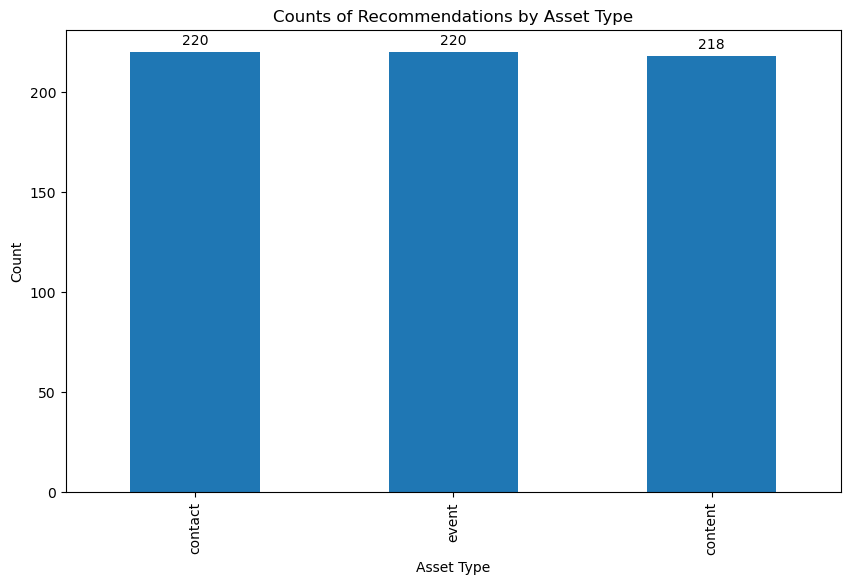

In [115]:
# Create a bar plot for counts of recommendations by asset_type
display_graph(recommendation_counts, 'Counts of Recommendations by Asset Type', 'Asset Type', 'Count', 10)

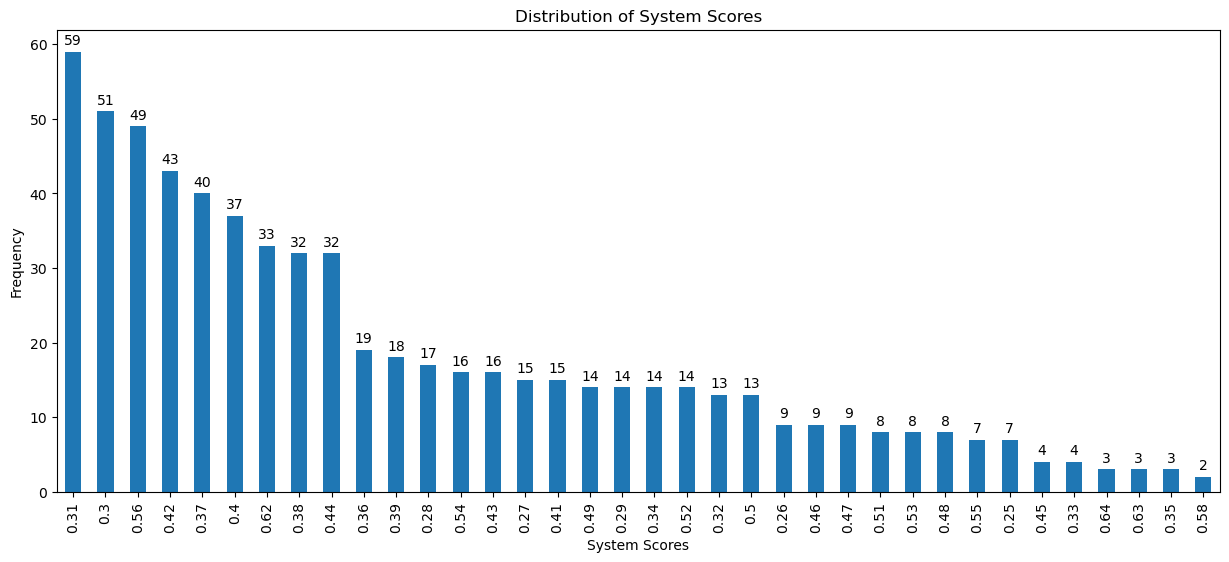

In [116]:
top_15_system_scores = recommendations_df_cleaned['system_score'].value_counts()
display_graph(top_15_system_scores, 'Distribution of System Scores', 'System Scores', 'Frequency', 15)

In [103]:
# Function to merge recommendations with appropriate dataset
def merge_recommendations(recommendations, contacts, content, events):
    # Separate recommendations by asset_type
    contact_recommendations = recommendations[recommendations['asset_type'] == 'contact']
    content_recommendations = recommendations[recommendations['asset_type'] == 'content']
    event_recommendations = recommendations[recommendations['asset_type'] == 'event']
    
    # Merge with appropriate dataset
    merged_contacts = pd.merge(contact_recommendations, contacts, left_on='asset_id', right_on='id', how='left')
    merged_content = pd.merge(content_recommendations, content, left_on='asset_id', right_on='id', how='left')
    merged_events = pd.merge(event_recommendations, events, left_on='asset_id', right_on='id', how='left')
    
    return [merged_contacts, merged_content, merged_events]
    
# Merge recommendations with appropriate datasets
merged_contacts, merged_content, merged_events = merge_recommendations(recommendations_df_cleaned, contacts_df_cleaned, content_df_cleaned, events_df_cleaned)

# Display the first few rows of the merged dataframe
merged_contacts

,id_x,title,asset_type,asset_id,organisation_id,user_id,creator_id,system_score,created_x,opened,...,last_name,email,role_id,city,country,state,created_y,linkedin_url,description,email_domain
0,6,David Gonzales | Founder of “A Cannabis Compan...,contact,290,1,98,98,0.51,1715376481,1.715380e+09,...,Gonzales,David_Gonzales@temporary.org,0,West Hollywood,United States,California,2024-05-09 14:35:41,https://www.linkedin.com/in/davidagonzales/,"Founder of “A Cannabis Company” , #ÅCannabis M...",temporary.org
1,7,"Emanuel Zareh | Investor, Professor. Focused o...",contact,150,1,98,143,0.47,1715376481,1.715384e+09,...,Zareh,emanuel.zareh@emles.com,0,New York,United States,New York,2024-05-09 14:35:41,https://www.linkedin.com/in/ezareh/,"Investor, Professor. Focused on venture capita...",emles.com
2,8,Harete Enriquez | Breakthrough Therapy for Peo...,contact,396,1,98,143,0.45,1715376481,1.715380e+09,...,Enriquez,Harete_Enriquez@temporary.org,0,Bethesda,United States,Maryland,2024-05-09 14:35:41,https://www.linkedin.com/in/harrete-enriquez-a...,Breakthrough Therapy for People Living with Pa...,temporary.org
3,9,Jaime Cahalan | COO at Stanley Brothers USA Ho...,contact,322,1,98,99,0.42,1715376481,1.715384e+09,...,Cahalan,jaime.cahalan@stanleybrothers.com,0,Charleston,United States,South Carolina,2024-05-09 14:35:41,https://www.linkedin.com/in/jaime-cahalan/,"COO at Stanley Brothers USA Holdings, Inc.",stanleybrothers.com
4,10,Gabrielle Feldman | Program Manager for the En...,contact,386,1,98,99,0.42,1715376481,1.715380e+09,...,Feldman,Gabrielle_Feldman@temporary.org,0,San Jose,United States,California,2024-05-09 14:35:41,https://www.linkedin.com/in/gabrielle-feldman-...,Program Manager for the Environmental Support ...,temporary.org
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,649,Ziva Cooper | Director of the UCLA Center for ...,contact,291,36,142,99,0.62,1715376724,1.715384e+09,...,Cooper,zcooper@mednet.ucla.edu,0,Los Angeles,United States,California,2024-05-09 14:35:41,https://www.linkedin.com/in/ziva-cooper-744a931/,Director of the UCLA Center for Cannabis and C...,mednet.ucla.edu
216,650,Laura Farren | Academic Research Partnerships ...,contact,402,36,142,144,0.56,1715376724,1.715384e+09,...,Farren,Laura_Farren@temporary.org,0,Brooklyn,United States,New York,2024-05-09 14:35:41,https://www.linkedin.com/in/laura-farren/?utm_...,Academic Research Partnerships @ CareEvolution...,temporary.org
217,651,Erin Alexander | Content @ TechGC,contact,416,36,142,99,0.56,1715376724,1.715384e+09,...,Alexander,erin@techgc.co,0,Chicago,United States,Illinois,2024-05-09 14:35:41,https://www.linkedin.com/in/ACoAABj70KIB65SI4a...,Content @ TechGC,techgc.co
218,652,"Ruben Seyde | “The Cannabis Guy” | Delivered, ...",contact,280,36,142,143,0.56,1715376724,1.715384e+09,...,Seyde,Ruben_Seyde@temporary.org,0,Boston,United States,Michigan,2024-05-09 14:35:41,https://www.linkedin.com/in/ruben-seyde/,"“The Cannabis Guy” | Delivered, Inc Founder | ...",temporary.org


In [133]:
# Top recommended contacts based on system_score
top_contacts = merged_contacts.nlargest(50, 'system_score').drop_duplicates(subset='asset_id')[['id_x', 'title', 'asset_id', 'system_score']]
top_contacts.head(5)

,id_x,title,asset_id,system_score
170,516,Christine Parman | Cannabis,220,0.64
171,517,Gabrielle Feldman | Program Manager for the En...,386,0.63
125,381,Ziva Cooper | Director of the UCLA Center for ...,291,0.62
21,67,Laura Farren | Academic Research Partnerships ...,402,0.58
22,68,Erin Alexander | Content @ TechGC,416,0.56


In [104]:
merged_content

,id_x,title_x,asset_type,asset_id,organisation_id,user_id,creator_id,system_score,created_x,opened,...,clicked_out,id_y,title_y,description,content_type,url,created_y,publication_date,text,advanced_sentiment
0,1,AFC Gamma is looking to finance unburdened can...,content,95,1,98,143,0.31,1715376481,1.715384e+09,...,1.715387e+09,95,AFC Gamma is looking to finance unburdened can...,Publicly traded cannabis industry lender AFC G...,article,https://mjbizdaily.com/afc-gamma-looks-to-unbu...,1715376400,"March 8, 2024",AFC Gamma is looking to finance unburdened can...,-0.009259
1,2,Massachusetts cannabis regulator expanding sec...,content,71,1,98,98,0.30,1715376481,1.715384e+09,...,NaN,71,Massachusetts cannabis regulator expanding sec...,Massachusetts Cannabis Control Commission (CCC...,article,https://mjbizdaily.com/massachusetts-expanding...,1715376400,"March 26, 2024",Massachusetts cannabis regulator expanding sec...,-0.250000
2,3,Institutional investor puts $50 million into c...,content,14,1,98,99,0.29,1715376481,1.715380e+09,...,NaN,14,Institutional investor puts $50 million into c...,Cannabis producer Canopy Growth raised gross p...,article,https://mjbizdaily.com/institutional-investor-...,1715376400,"May 3, 2024",Institutional investor puts $50 million into c...,-0.050000
3,4,AFC Gamma provides $34 million to Sunburn Cann...,content,69,1,98,144,0.28,1715376481,1.715384e+09,...,NaN,69,AFC Gamma provides $34 million to Sunburn Cann...,Marijuana industry lender AFC Gamma provided $...,article,https://mjbizdaily.com/afc-gamma-provides-34-m...,1715376400,"March 27, 2024",AFC Gamma provides $34 million to Sunburn Cann...,0.000000
4,5,Cannabis operator Canopy raising $35 million i...,content,2,1,98,98,0.27,1715376481,1.715384e+09,...,1.715384e+09,2,Cannabis operator Canopy raising $35 million i...,Canadian cannabis company Canopy Growth Corp. ...,article,https://mjbizdaily.com/cannabis-operator-canop...,1714286073,NaN,Cannabis operator Canopy raising $35 million i...,-0.023967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,644,Largest cannabis MSOs lay out modest expansion...,content,137,36,142,98,0.38,1715376724,1.715384e+09,...,1.715388e+09,137,Largest cannabis MSOs lay out modest expansion...,Several of the nations largest cannabis compan...,article,https://mjbizdaily.com/largest-cannabis-msos-l...,1715376400,"January 4, 2024",Largest cannabis MSOs lay out modest expansion...,0.021645
214,645,Second round for Missouri cannabis microbusine...,content,100,36,142,144,0.32,1715376724,1.715384e+09,...,NaN,100,Second round for Missouri cannabis microbusine...,Missouri regulators will begin accepting the s...,article,https://mjbizdaily.com/second-round-for-missou...,1715376400,"March 6, 2024",Second round for Missouri cannabis microbusine...,-0.100000
215,646,How R&D cannabis lines help cultivators conduc...,content,82,36,142,143,0.31,1715376724,1.715384e+09,...,1.715388e+09,82,How R&D cannabis lines help cultivators conduc...,"R&D cannabis lines or limited-edition, small-...",article,https://mjbizdaily.com/how-limited-edition-can...,1715376400,"March 18, 2024",How R&D cannabis lines help cultivators conduc...,0.000000
216,647,"280E, new markets and wholesale revenue highli...",content,76,36,142,143,0.31,1715376724,NaN,...,NaN,76,"280E, new markets and wholesale revenue highli...",Tax strategies took the spotlight in fourth-qu...,article,https://mjbizdaily.com/280e-new-markets-wholes...,1715376400,"March 21, 2024","280E, new markets and wholesale revenue highli...",0.000000


In [132]:
# Top recommended content based on system_score
top_content = merged_content.nlargest(50, 'system_score').drop_duplicates(subset='asset_id')[['id_x', 'title_x', 'asset_id', 'system_score']]
top_content.head(5)

,id_x,title_x,asset_id,system_score
155,466,Cannabis operator Canopy raising $35 million i...,2,0.40
20,61,Largest cannabis MSOs lay out modest expansion...,137,0.38
156,467,Institutional investor puts $50 million into c...,14,0.38
158,469,AFC Gamma provides $34 million to Sunburn Cann...,69,0.37
159,470,Chicago Atlantic lends $20 million to Nova Far...,45,0.36


In [105]:
merged_events

,id_x,title_x,asset_type,asset_id,organisation_id,user_id,creator_id,system_score,created_x,opened,...,start,end,location,url,price,created_y,last_modified,lon,lat,duration
0,11,Supply Chain Challenges and Cannabis: A Global...,event,1208,1,98,99,0.46,1715376481,1.715380e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/su...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000
1,12,Fund Your Business: Options for Raising Capita...,event,1246,1,98,98,0.46,1715376481,1.715380e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/fu...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000
2,13,Upwise Capital: Cannabis Business Financing on...,event,1203,1,98,143,0.41,1715376481,1.715380e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/up...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000
3,14,Medicinal Applications of Cannabis for Cancer ...,event,436,1,98,143,0.34,1715376481,1.715380e+09,...,2024-01-01 17:59:28,2024-01-01 17:59:28,"Cincinnati, OH",https://www.eventbrite.com/e/medicinal-applica...,Not available,1.711441e+09,1.714921e+09,-84.512460,39.101454,0.000000
4,15,Essential Cannabis Businesses and COVID-19: Ad...,event,1241,1,98,98,0.33,1715376481,1.715384e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/co...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,654,Agrify: From Flower to Diamonds How to Use Te...,event,1194,36,142,98,0.47,1715376724,1.715384e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/ag...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000
216,655,Surna: What to Expect When You're Expanding or...,event,1245,36,142,99,0.44,1715376724,1.715380e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/su...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000
217,656,Agrify: From Flower to Diamonds How to Use Te...,event,1192,36,142,98,0.44,1715376724,1.715380e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/ag...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000
218,657,Supporting the Cannabis Industry with Industry...,event,1254,36,142,144,0.43,1715376724,1.715384e+09,...,1970-01-01 00:00:00,1970-01-01 00:00:00,online,https://www.cannabisbusinesstimes.com/media/ca...,Free,1.715368e+09,0.000000e+00,0.000000,0.000000,0.000000


In [131]:
# Top recommended events based on system_score
top_events = merged_events.nlargest(50, 'system_score').drop_duplicates(subset='asset_id')[['id_x', 'title_x', 'asset_id', 'system_score']]
top_events.head(5)

,id_x,title_x,asset_id,system_score
65,206,Hiring in the 21st Century. How Your Cannabis ...,1256,0.50
85,266,Agrify: From Flower to Diamonds How to Use Te...,1194,0.47
0,11,Supply Chain Challenges and Cannabis: A Global...,1208,0.46
1,12,Fund Your Business: Options for Raising Capita...,1246,0.46
86,267,Surna: What to Expect When You're Expanding or...,1245,0.44


# ----------------------------------------------------------------------------------------------------------------

# Users